# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# Only necessary when executing this notebook on the Udacity cloud
#!pip -q install ../python

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import os
import time

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
# Standalone machine
#env = UnityEnvironment( os.path.join( os.environ['HOME'], 'Python/rl/udadrl/data/Banana_Linux/Banana.x86_64' ) ) # Visible (Best 4 testing)
env = UnityEnvironment( os.path.join( os.environ['HOME'], 'Python/rl/udadrl/data/Banana_Linux_NoVis/Banana.x86_64' ) ) # Invisible (Best 4 training)

# Udacity cloud
#env = UnityEnvironment( file_name="/data/Banana_Linux_NoVis/Banana.x86_64" )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
from dql_agent import Agent

agent = Agent(state_size, action_size, time.time())

# Helper functions
def get_time_string():
    return time.strftime('%Y%m%d%H%M%S')

In [7]:
scores = []  # List with all scores per episode
scores_100_mean = 0 # Mean score over the last 100 episodes

for epc in range(4000):

    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0     # initialize the score
    

    start_time = time.time()

    while True:
        action = agent.act(state)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    scores.append(score)
    if len(scores) >= 100:
        scores_100_mean = np.mean( scores[-100:] )
        
    
    stop_time = time.time()

    print( '\rEpoch:{:>5}; Score: {:>5}; Execution time: {:.4f}; Mean (100): {:+3.2f}'.format( epc+1, score, stop_time - start_time, scores_100_mean ), \
          end = ' ')
    if ( epc+1 ) % 100 == 0:       
        print('*')
        
    if (scores_100_mean > 14):
        print('#')
        # print( 'Udacity criterion reached (Mean of recent 100 runs > 13), enviroment is considered as solved!')
        print( 'My criterion reached (Mean of recent 100 runs > 14), enviroment is considered as solved!')
        break


Epoch:  100; Score:   0.0; Execution time: 0.7300; Mean (100): +0.03 *
Epoch:  200; Score:   1.0; Execution time: 0.7043; Mean (100): -0.15 *
Epoch:  300; Score:   1.0; Execution time: 0.6869; Mean (100): -0.01 *
Epoch:  400; Score:   0.0; Execution time: 0.7114; Mean (100): +0.19 *
Epoch:  500; Score:   0.0; Execution time: 0.7057; Mean (100): +0.04 *
Epoch:  600; Score:   1.0; Execution time: 0.6652; Mean (100): +0.05 *
Epoch:  700; Score:  -2.0; Execution time: 0.6975; Mean (100): -0.25 *
Epoch:  800; Score:  -2.0; Execution time: 0.6781; Mean (100): +0.20 *
Epoch:  900; Score:   0.0; Execution time: 0.6811; Mean (100): +0.03 *
Epoch: 1000; Score:   0.0; Execution time: 0.7078; Mean (100): -0.01 *
Epoch: 1100; Score:  -1.0; Execution time: 0.6934; Mean (100): -0.09 *
Epoch: 1200; Score:   0.0; Execution time: 0.6933; Mean (100): -0.08 *
Epoch: 1300; Score:   0.0; Execution time: 0.6595; Mean (100): -0.26 *
Epoch: 1400; Score:   0.0; Execution time: 0.6540; Mean (100): +0.04 *
Epoch:

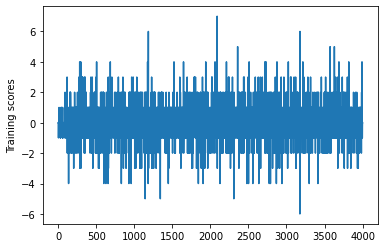

In [8]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.ylabel('Training scores')
plt.show()

In [9]:
# Thx2: https://pytorch.org/tutorials/beginner/saving_loading_models.html

import torch

torch.save(agent.qnetwork_local.state_dict(), './output/' + get_time_string() + '_qnetwork_local_statedict.pth')


In [10]:
env.close()

# Watch the trained agent in action!

In [ ]:
from dql_agent import Agent

agent = Agent(state_size, action_size)

In [ ]:
import torch

# FA The network from my GPU training run did not load
# Thx 2: https://stackoverflow.com/a/55759312

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
    print('CUDA')
else:
    map_location='cpu'
    print('CPU')
    


# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('./output/20200706160011_qnetwork_local_statedict.pth', map_location=map_location))
agent.qnetwork_local.eval() #Set Network in evaluation mode - important!




In [ ]:
score_sum = 0

for epc in range(5):

    env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0     # initialize the score

    start_time = time.time()

    while True:
        action = agent.act(state)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        # agent.step(state, action, reward, next_state, done) # not step needed in evaluation
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    stop_time = time.time()
    score_sum += score
    print( "Epoch:{:>5}; Score: {:>5}; Execution time: {:.4f}".format( epc+1, score, stop_time - start_time ) )

print( 'Achieved mean over {} test runs: {}'.format( ( epc+1 ), score_sum / (epc+1) ) )


In [ ]:
env.close()